In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

In [2]:
df = pd.read_csv("/kaggle/input/finaldset/sir-data.csv")
df.head(1100)

,label,tweet
0,0.0,pura maal disucha
1,0.0,maal te hoichu be
2,0.0,to aga ta vala disuchi
3,1.0,besi gandi marena
4,1.0,pellei pua ta
...,...,...
1095,1.0,Tampudi mundare unkuni
1096,0.0,samaya bancha
1097,0.0,Rasta ra bama pate chala
1098,0.0,Sabu chamkuthiba bastu suna nuha


In [3]:
hate_tweet = df[df.label == 1]
hate_tweet.head()

,label,tweet
3,1.0,besi gandi marena
4,1.0,pellei pua ta
5,1.0,to pacha pate baunsa purei debi
6,1.0,tamar kn disuchi
7,1.0,mate syamali pasanda


In [4]:
normal_tweet = df[df.label == 0]
normal_tweet.head()

,label,tweet
0,0.0,pura maal disucha
1,0.0,maal te hoichu be
2,0.0,to aga ta vala disuchi
8,0.0,to patire purei debi
9,0.0,to pela pathei debi


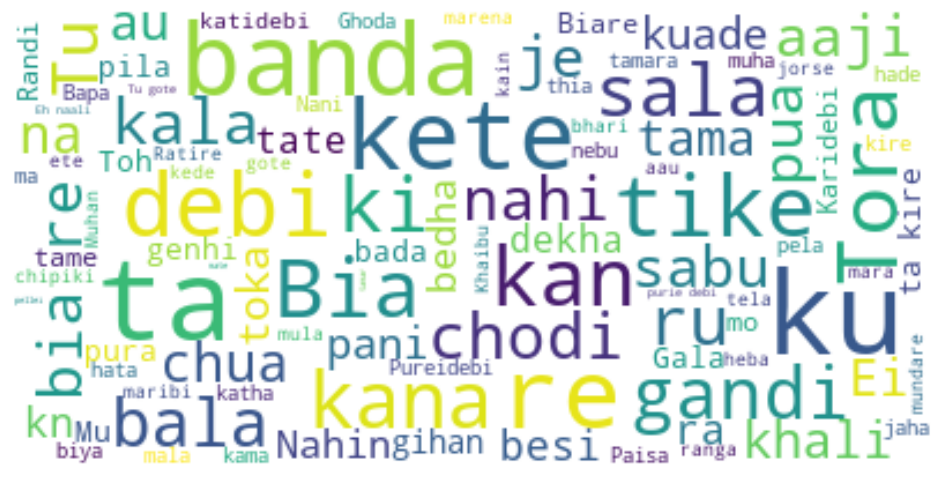

In [5]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in hate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0.0,463,41.900452
1,1.0,642,58.099548


In [7]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [8]:
df['processed_tweets'] = df['tweet'].apply(process_tweet)
df.head()

,label,tweet,processed_tweets
0,0.0,pura maal disucha,pura maal disucha
1,0.0,maal te hoichu be,maal te hoichu be
2,0.0,to aga ta vala disuchi,to aga ta vala disuchi
3,1.0,besi gandi marena,besi gandi marena
4,1.0,pellei pua ta,pellei pua ta


In [9]:
cnt_non_fraud = df[df['label'] == 0]['processed_tweets'].count()
df_class_fraud = df[df['label'] == 1]
df_class_nonfraud = df[df['label'] == 0]
df_class_fraud_oversample = df_class_fraud.sample(cnt_non_fraud, replace=True)
df_oversampled = pd.concat([df_class_nonfraud, df_class_fraud_oversample], axis=0)

print('Random over-sampling:')
print(df_oversampled['label'].value_counts())

Random over-sampling:
0.0    463
1.0    463
Name: label, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [12]:
x_train_counts = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [13]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(740, 947)
(740, 947)


In [14]:
x_test_counts = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(n_estimators=500)

In [16]:
predictions = model.predict(x_test_tfidf)

In [17]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[66 23]
 [37 60]]
              precision    recall  f1-score   support

         0.0       0.64      0.74      0.69        89
         1.0       0.72      0.62      0.67        97

    accuracy                           0.68       186
   macro avg       0.68      0.68      0.68       186
weighted avg       0.68      0.68      0.68       186



In [18]:
#Building XGBoost Model
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_tfidf,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.9, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=22,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
predict_xgb = model_bow.predict(x_test_tfidf)

In [20]:
print(confusion_matrix(y_test,predict_xgb))
print(classification_report(y_test,predict_xgb))

[[65 24]
 [38 59]]
              precision    recall  f1-score   support

         0.0       0.63      0.73      0.68        89
         1.0       0.71      0.61      0.66        97

    accuracy                           0.67       186
   macro avg       0.67      0.67      0.67       186
weighted avg       0.67      0.67      0.67       186



In [21]:
#SVM Model
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)

LinearSVC()

In [22]:
predict_svm = lin_clf.predict(x_test_tfidf)

In [23]:
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[58 31]
 [34 63]]
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64        89
         1.0       0.67      0.65      0.66        97

    accuracy                           0.65       186
   macro avg       0.65      0.65      0.65       186
weighted avg       0.65      0.65      0.65       186



In [24]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [25]:
logreg = LogisticRegression(random_state=42)

In [26]:
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

LogisticRegression(random_state=42)

In [27]:
predict_log = logreg.predict(x_test_tfidf)


In [28]:
print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[58 31]
 [32 65]]
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65        89
         1.0       0.68      0.67      0.67        97

    accuracy                           0.66       186
   macro avg       0.66      0.66      0.66       186
weighted avg       0.66      0.66      0.66       186



In [29]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train_tfidf, y_train)

MultinomialNB()

In [30]:
predict_nb = NB.predict(x_test_tfidf)

In [31]:
print(confusion_matrix(y_test,predict_nb))
print(classification_report(y_test, predict_nb))

[[56 33]
 [30 67]]
              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64        89
         1.0       0.67      0.69      0.68        97

    accuracy                           0.66       186
   macro avg       0.66      0.66      0.66       186
weighted avg       0.66      0.66      0.66       186



In [32]:
#Test Data Set
df_test = pd.read_csv("/kaggle/input/dataset/sir-data.csv")
df_test.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/dataset/sir-data.csv'

In [ ]:
df_test.shape

In [ ]:
df_test['processed_tweets'] = df_test['tweet'].apply(process_tweet)
df_test.head()

In [ ]:
X = df_test['processed_tweets']
x_test_counts = count_vect.transform(X)
x_test_tfidf = transformer.transform(x_test_counts)

In [ ]:
df_test['predict_nb'] = NB.predict(x_test_tfidf)
df_test[df_test['predict_nb']==1]

In [ ]:
df_test['predict_svm'] = NB.predict(x_test_tfidf)
df_test['predict_rf'] = model.predict(x_test_tfidf)
df_test.head()

In [ ]:
file_name = 'test_predictions_Twitter Hate Analysis.csv'
df_test.to_csv(file_name,index=False)